## Paso 0: Instalo las dependencias

In [1]:
!pip install cplex docplex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
import string

#Cplex en python
from docplex.mp.model import Model
import docplex.mp.solution as Solution

## Paso 1: Obtengo la información de los bancos

### Obtengo las distancias entre bancos

In [3]:
distances = pd.read_csv('distancias.csv', header=None)
banks = ['0'] + list(string.ascii_uppercase)[:len(distances)-1]
distances.columns = banks
distances.columns 
distances.index = banks
distances

,0,A,B,C,D,E,F,G,H,I,J
0,0,80,88,19,30,43,21,58,87,83,7
A,80,0,32,14,3,88,92,55,18,42,70
B,88,32,0,92,3,11,46,28,43,75,64
C,19,14,92,0,91,42,23,100,41,38,35
D,30,3,3,91,0,41,31,35,18,94,84
E,43,88,11,42,41,0,79,66,22,48,61
F,21,92,46,23,31,79,0,85,32,93,84
G,58,55,28,100,35,66,85,0,90,100,13
H,87,18,43,41,18,22,32,90,0,42,70
I,83,42,75,38,94,48,93,100,42,0,60


### Obtengo la ganancia/ perdida que da cada banco

In [4]:
capital = pd.read_csv('ganancias.csv', header=None)
capital.index = banks[1:]
capital

,0
A,20
B,-30
C,40
D,15
E,-20
F,-25
G,10
H,-40
I,20
J,5


In [5]:
capital.loc['H'] = -10

In [6]:
capital

,0
A,20
B,-30
C,40
D,15
E,-20
F,-25
G,10
H,-10
I,20
J,5


Seteo MAX_DINERO a un numero arbitriario y M a un numero grande

In [7]:
MAX_DINERO = int(capital.max()*1.5)
MAX_DINERO

60

In [8]:
MAX_DINERO = 40

In [9]:
M = int(capital.abs().sum())
M

195

## Paso 2: Grafico la posición relativa de los bancos usando el algoritmo MDS

Esta representación no es perfecta ya que las distancias
son inventadas por lo que hay inconsistencias.

In [10]:
# Perform MDS to estimate the positions of the banks
mds = MDS(n_components=2, dissimilarity='precomputed')
positions = mds.fit_transform(distances)

# Print the estimated positions of the banks
dist = dict()

for i in range(distances.shape[0]):
  label = distances.index[i]
  x = positions[i,0]
  y = positions[i,1]
  dist[label] = (x, y)

dist

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


{'0': (-34.42618678963001, -17.137975720732857),
 'A': (24.075138064344173, -6.333938002882364),
 'B': (5.694976985430961, 33.56189911080968),
 'C': (3.3145509896675245, -35.95184316675623),
 'D': (1.7646681302416758, 19.174862715066276),
 'E': (18.515671363414857, 29.26161980369601),
 'F': (-18.446954692086404, -36.116446845698526),
 'G': (-36.12105366840359, 36.37595027509075),
 'H': (28.309760243011063, 1.9836084779485295),
 'I': (49.00469141575201, -27.21764895984884),
 'J': (-41.68526204174228, 2.3999123133075493)}

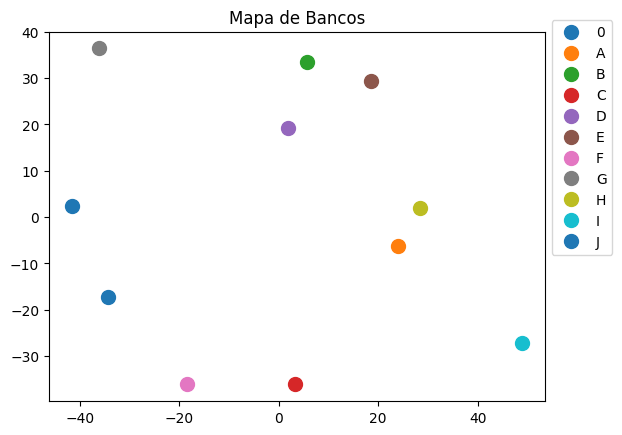

In [11]:
# Create a plot
fig, ax = plt.subplots()

# Plot the banks as dots
for bank in dist:
    ax.plot(dist[bank][0], dist[bank][1], 'o', markersize=10, label=bank)

# Add the legend
ax.legend(bbox_to_anchor=(1.15, 1.05))

# Add the title
plt.title("Mapa de Bancos")

# Show the plot
plt.show()

## Paso 3: Creo el modelo

In [12]:
model = Model('TSP', log_output=True)

### Variables

In [13]:
u = model.continuous_var_list(range(1, len(banks)), 1, len(banks)-1, name="U")

In [14]:
Yij_duplas = [(i, j) for i in banks for j in banks if i != j]
Yij = model.binary_var_dict(Yij_duplas, name='Y')

Se resuelve con el metodo 3 ya que los otros 2 ya estan resueltos en CPLEX \
$-M * (1-Y_{ij}) <= T_i + cte_j -T_j <= (1-Y_{ij}) * M$

In [15]:
def T_name(key):
  return "T_" + banks[key]

In [16]:
Ti = model.continuous_var_list(range(0, len(banks)), 0, MAX_DINERO, name=T_name)

### Subject to

In [17]:
for b in banks:
  model.add_constraint(model.sum(Yij[(i, j)] for i,j in Yij_duplas if i == b) == 1, ctname=f"sumatoriaSalidaDa1_{b}")

In [18]:
for b in banks:
  model.add_constraint(model.sum(Yij[(i, j)] for i,j in Yij_duplas if j == b) == 1, ctname=f"sumatoriaEntradaDa1_{b}")

In [19]:
N = len(banks)

In [20]:
for i in range(0, N-1):
  for j in range(0, N-1):
    if (i == j): continue
    model.add_constraint(u[i] - u[j] + N * Yij[(banks[i+1],banks[j+1])] <= N - 1, \
                         'U_' + str(i+1) + '_'+ str(j+1))

Creo que copie la formula mal en el cuaderno si la pueden cambiar

$-M * (1-Y_{ij}) <= T_i + cte_j -T_j <= (1-Y_{ij}) * M$ \
$-M +M Y_{ij} <= T_i + cte_j -T_j <= M -MY_{ij}$ \
$M Y_{ij}-M<= T_i + cte_j -T_j <= M -MY_{ij}$ \

Que se divide en dos para el software \
1. \
$M Y_{ij} - M <= T_i + cte_j -T_j $ \
$M Y_{ij} - T_i + T_j <= cte_j +M $ \

2. \
$ T_i + cte_j -T_j <= M -MY_{ij} $ \
$ MY_{ij} + T_i -T_j <= M - cte_j $ \


In [21]:
for i in range(0, N):
  for j in range(0, N):
    if i == j: continue
    if j == 0:continue
    cte_j = int(capital.loc[banks[j]])
    #1
    model.add_constraint((M * Yij[ (banks[i], banks[j]) ] - Ti[i] + Ti[j]) <= (M + cte_j),
                         ctname = "T_" + banks[i] + "_" + banks[j] + "_1")
    #2
    model.add_constraint((M * Yij[ (banks[i], banks[j]) ] + Ti[i] - Ti[j]) <= (M - cte_j),
                         ctname = "T_" + banks[i] + "_" + banks[j] + "_2")

In [22]:
model.add_constraint(Ti[0] == 0)

docplex.mp.LinearConstraint[](T_0,EQ,0)

In [23]:
#for i in range (1, N):
#  model.add_constraint(Ti[i] >= 0)

### Funcional

In [24]:
model.minimize(model.sum(distances[i[0]][i[1]] * Yij[i] for i in Yij_duplas))

### Resumen del modelo

In [25]:
print(model.export_to_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: TSP

Minimize
 obj: 80 Y_0_A + 88 Y_0_B + 19 Y_0_C + 30 Y_0_D + 43 Y_0_E + 21 Y_0_F + 58 Y_0_G
      + 87 Y_0_H + 83 Y_0_I + 7 Y_0_J + 80 Y_A_0 + 32 Y_A_B + 14 Y_A_C + 3 Y_A_D
      + 88 Y_A_E + 92 Y_A_F + 55 Y_A_G + 18 Y_A_H + 42 Y_A_I + 70 Y_A_J
      + 88 Y_B_0 + 32 Y_B_A + 92 Y_B_C + 3 Y_B_D + 11 Y_B_E + 46 Y_B_F
      + 28 Y_B_G + 43 Y_B_H + 75 Y_B_I + 64 Y_B_J + 19 Y_C_0 + 14 Y_C_A
      + 92 Y_C_B + 91 Y_C_D + 42 Y_C_E + 23 Y_C_F + 100 Y_C_G + 41 Y_C_H
      + 38 Y_C_I + 35 Y_C_J + 30 Y_D_0 + 3 Y_D_A + 3 Y_D_B + 91 Y_D_C + 41 Y_D_E
      + 31 Y_D_F + 35 Y_D_G + 18 Y_D_H + 94 Y_D_I + 84 Y_D_J + 43 Y_E_0
      + 88 Y_E_A + 11 Y_E_B + 42 Y_E_C + 41 Y_E_D + 79 Y_E_F + 66 Y_E_G
      + 22 Y_E_H + 48 Y_E_I + 61 Y_E_J + 21 Y_F_0 + 92 Y_F_A + 46 Y_F_B
      + 23 Y_F_C + 31 Y_F_D + 79 Y_F_E + 85 Y_F_G + 32 Y_F_H + 93 Y_F_I
      + 84 Y_F_J + 58 Y_G_0 + 55 Y_G_A + 28 Y_G_B + 100 Y_G_C + 35 Y_G_D
      + 66 Y_G_

## Paso 4: Resuelvo con CPLEX

In [26]:
solution = model.solve()

Version identifier: 22.1.1.0 | 2023-02-11 | 22d6266e5
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 19 rows and 5 columns.
MIP Presolve modified 544 coefficients.
Reduced MIP has 294 rows, 126 columns, and 1017 nonzeros.
Reduced MIP has 106 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.52 ticks)
Found incumbent of value 621.000000 after 0.01 sec. (1.81 ticks)
Probing fixed 16 vars, tightened 0 bounds.
Probing time = 0.00 sec. (0.48 ticks)
Cover probing fixed 1 vars, tightened 31 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 57 rows and 17 columns.
MIP Presolve modified 244 coefficients.
Reduced MIP has 237 rows, 109 columns, and 812 nonzeros.
Reduced MIP has 90 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.41 ticks)
Probing time = 0.00 sec. (0.34 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 237 rows, 109 columns, and 812 nonzeros.
Red

In [27]:
model.get_solve_status() # 2 = TODO OK

<JobSolveStatus.OPTIMAL_SOLUTION: 2>

In [28]:
final_values = solution.as_df()
final_values

,name,value
0,U_1,6.0
1,U_2,8.0
2,U_3,1.0
3,U_4,7.0
4,U_5,4.0
5,U_6,2.0
6,U_7,9.0
7,U_8,5.0
8,U_9,3.0
9,U_10,10.0


## Paso 5: Grafico la solución

Creo las conexiones

In [29]:
final_values.iloc[N-1:2*N-1]

,name,value
10,Y_0_C,1.0
11,Y_A_D,1.0
12,Y_B_G,1.0
13,Y_C_F,1.0
14,Y_D_B,1.0
15,Y_E_H,1.0
16,Y_F_I,1.0
17,Y_G_J,1.0
18,Y_H_A,1.0
19,Y_I_E,1.0


In [30]:
def obtener_bancos(row):
  bancos = row["name"].split("_")
  return bancos[1], bancos[2]

In [31]:
# Define the connections between the banks
# Sería el recorrido del camión
connections = final_values.iloc[N-1:2*N-1]
connections = connections.apply(obtener_bancos, axis=1)
connections = list(connections)
connections

[('0', 'C'),
 ('A', 'D'),
 ('B', 'G'),
 ('C', 'F'),
 ('D', 'B'),
 ('E', 'H'),
 ('F', 'I'),
 ('G', 'J'),
 ('H', 'A'),
 ('I', 'E'),
 ('J', '0')]

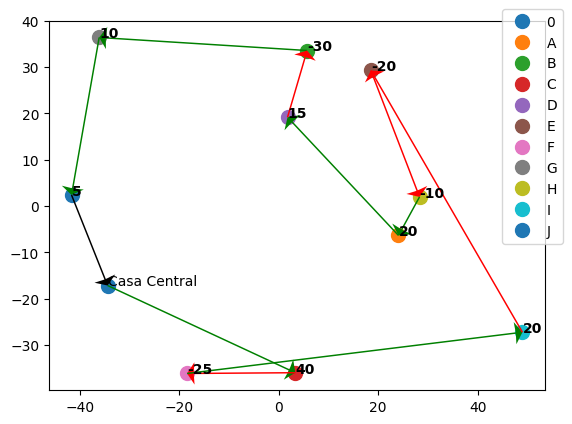

In [32]:
casa_central = banks[0]

# Create a plot
fig, ax = plt.subplots()

# Plot the banks as dots
for bank in dist:
    ax.plot(dist[bank][0], dist[bank][1], 'o', markersize=10, label=bank)

# Plot the connections as arrows
for connection in connections:
  x1, y1 = dist[connection[0]]
  x2, y2 = dist[connection[1]]
  dx, dy = x2 - x1, y2 - y1
  
  if connection[1] == casa_central:
    color = 'black'
  else:
    cambio = int(capital.loc[connection[1]])
    if cambio > 0:
      color = 'green'
    else:
      color = 'red'
  
  ax.quiver(x1, y1, dx, dy,
            angles='xy', scale_units='xy',
            scale=1, width=0.003,
            headwidth=15, color=color,
            zorder=3)

# Annotate the Casa Central
ax.annotate('Casa Central', dist[casa_central])

# Annotate the capital
for b in banks[1:]:
  ax.annotate(int(capital.loc[b]), dist[b], weight="bold")

# Add the legend
ax.legend(bbox_to_anchor=(1.05, 1.05))

# Show the plot
plt.show()